##Imports

In [41]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

from google.colab import files
import pandas as pd
from pytorch_pretrained_bert import BertTokenizer
import nltk
import re
nltk.download('punkt')
from keras.preprocessing.sequence import pad_sequences

from pytorch_pretrained_bert import BertModel, BertForMaskedLM

import matplotlib.pyplot as plt
% matplotlib inline

Found GPU at: /device:GPU:0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
!pip install pytorch-pretrained-bert pytorch-nlp

     |████████████████████████████████| 133kB 6.4MB/s 
     |████████████████████████████████| 92kB 10.5MB/s 


##Load data

In [3]:
# Upload the train file from your local drive
uploaded = files.upload()

Saving all_files.txt to all_files.txt


In [4]:
df = pd.read_csv("all_files.txt", delimiter='\n', header=None)
df.sample(5)

,0
17,"In the United States, the modern use of the te..."
31,I agree with you - Students do need to learn h...
9,"On the topic of the Native American languages,..."
25,Sorry if youve heard it a million times before...
14,"Looking through the comments, I see a lot of p..."


##Tokenization

In [81]:
def getSentences(df):
  max_length_sentence = 0
  sentences = []
  for key, value in df.iteritems(): 
      for i, e in enumerate(value):
        sentence = nltk.tokenize.sent_tokenize(e)
        max_length_sentence = max(max_length_sentence, len(sentence))
        sentences = sentences + sentence
  print("\nSentence: ", sentences[0])
  print("Number of sentences: ", len(sentences))
  print("Maximum lenght of sentence:", max_length_sentence)
  return sentences

def removeWikification(sentences):
  newSentences = []
  wikification = ['Wiki__','wiki__','wiki_','Wiki_','wiki','Wiki']
  
  for sentence in sentences:
    new_str = sentence.lower()
    tokens = new_str.split()
    wiki_words =[]

    # Find the wiki words
    for token in tokens:
        if token.find('wiki') == 0:
            wiki_words.append(token)
    
    # Get wikification
    for word in wiki_words:
      wikification.append('__'+(word.rsplit('_', 1))[1])
    
    # Remove wikification
    for string in wikification:
      sentence = sentence.replace(string,'')
    
    newSentences.append(sentence)
    
  res2 = [sub.replace('___', ' ') for sub in newSentences]
  res1 = [sub.replace('__', ' ') for sub in res2]
  res = [sub.replace('_', ' ') for sub in res1]
  print("\nNo wiki sentence: ", res[0])
  
  return res

sentences = getSentences(df)
sentences_without_wiki = removeWikification(sentences)
sentences_sep = ["[CLS] " + sentence + " [SEP]" for sentence in sentences_without_wiki]
print("\nSentence with sep: ", sentences_sep[0])

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenized_texts = [tokenizer.tokenize(sentence) for sentence in sentences_sep]
print ("\nTokenized sentence:", tokenized_texts[0])
print("Number of tokens for first sentence:", len(tokenized_texts[0]))


Sentence:  I am also currently seeking my degree from said institution and I am shocked and awed everyday by the mindlessness of the students.
Number of sentences:  909
Maximum lenght of sentence: 93

No wiki sentence:  I am also currently seeking my degree from said institution and I am shocked and awed everyday by the mindlessness of the students.

Sentence with sep:  [CLS] I am also currently seeking my degree from said institution and I am shocked and awed everyday by the mindlessness of the students. [SEP]

Tokenized sentence: ['[CLS]', 'i', 'am', 'also', 'currently', 'seeking', 'my', 'degree', 'from', 'said', 'institution', 'and', 'i', 'am', 'shocked', 'and', 'awe', '##d', 'everyday', 'by', 'the', 'mind', '##lessness', 'of', 'the', 'students', '.', '[SEP]']
Number of tokens for first sentence: 28


In [17]:
# Set the maximum sequence length. The longest sequence in our training set is 93, but we'll leave room on the end anyway. 
# In the original paper, the authors used a length of 512.
MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
indexed_tokens = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

# Display the words with their indeces for the first sentence.
for tup in zip(tokenized_texts[0], indexed_tokens[0]):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

# Pad our input tokens
input_ids = pad_sequences(indexed_tokens, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

[CLS]           101
i             1,045
am            2,572
also          2,036
currently     2,747
seeking       6,224
my            2,026
degree        3,014
from          2,013
said          2,056
institution   5,145
and           1,998
i             1,045
am            2,572
shocked       7,135
and           1,998
awe          15,180
##d           2,094
everyday     10,126
by            2,011
the           1,996
mind          2,568
##lessness   24,913
of            1,997
the           1,996
students      2,493
.             1,012
[SEP]           102


##Segment ID

In [21]:
#BERT expects sentence pairs, 1 and 0s to distinguish. We have single-sentence 
#inputs so it requires a serie of 1s

# Mark each of the tokens as belonging to sentence "1".
segments_ids = [[1] * len(text) for text in tokenized_texts]

print (len(segments_ids[0]))

28


##Extracting embeddings

###Running BERT

In [0]:
# We need to convert our data to torch tensors and call the BERT model

# Convert inputs to PyTorch tensors
tokens_tensors = [torch.tensor([tokens]) for tokens in indexed_tokens]
segments_tensors = [torch.tensor([segment]) for segment in segments_ids]

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased')

# Put the model in "evaluation" mode, meaning feed-forward operation.
# Evaluation mode turns off dropout regularization which is used in training
model.eval()

In [38]:
# Let’s fetch the hidden states of the network
# Deactivates the gradient calculations, saves memory, and speeds up computation
# Predict hidden states features for each layer
encoded_layers = [None] * len(tokens_tensors)
print(len(tokens_tensors))
i = 0
for tokens_tensor, segments_tensor in zip(tokens_tensors, segments_tensors):
  with torch.no_grad():
      encoded_layers[i], _ = model(tokens_tensor, segments_tensor)
  i += 1

909


###Understanding the output

In [39]:
# One object of encoded_layers has four dimensions:
# The layer number
# The batch number
# The word / token number in one sentence
# The hidden unit / feature number

# For the first sentence:
print ("Number of layers:", len(encoded_layers[0]))
layer_i = 0

print ("Number of batches:", len(encoded_layers[0][layer_i]))
batch_i = 0

print ("Number of tokens:", len(encoded_layers[0][layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(encoded_layers[0][layer_i][batch_i][token_i]))

Number of layers: 12
Number of batches: 1
Number of tokens: 28
Number of hidden units: 768


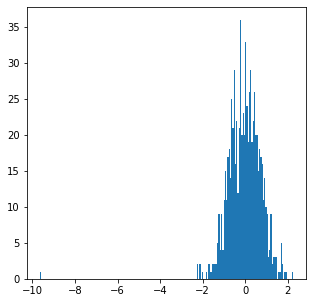

In [43]:
# Range of values for a given layer and token
# For the 5th token in our sentence, select its feature values from layer 5.
token_i = 5
layer_i = 5
vec = encoded_layers[0][layer_i][batch_i][token_i]

# Plot the values as a histogram to show their distribution.
plt.figure(figsize=(5,5))
plt.hist(vec, bins=200)
plt.show()

In [45]:
# Grouping the values by layer makes sense for the model,
# but for our purposes we want it grouped by token

# Current dimensions: [# layers, # batches, # tokens, # features]
# Desired dimensions: [# tokens, # layers, # features]

# BUT `encoded_layers objects` are Python lists.
print('Type of encoded_layers: ', type(encoded_layers[0]))

# Each layer in the list object is a torch tensor. (28 for first sentence)
print('Tensor shape for each layer: ', encoded_layers[0][0].size())

Type of encoded_layers:  <class 'list'>
Tensor shape for each layer:  torch.Size([1, 28, 768])


In [53]:
# Let's reshape

# Concatenate the tensors for all layers. We use `stack` here to
# create a new dimension in the tensor

token_embeddings = [torch.stack(encoded_layer, dim=0) for encoded_layer in encoded_layers]
print('Layers concatenated:', token_embeddings[0].size())

# Let’s get rid of the “batches” dimension since we don’t need it
# Remove dimension 1, the "batches"

token_embeddings = [torch.squeeze(token_embedding, dim=1) for token_embedding in token_embeddings]
print('Batches removed:', token_embeddings[0].size())

# Finally, we can switch around the “layers” and “tokens” dimensions
# Swap dimensions 0 and 1

token_embeddings = [token_embedding.permute(1,0,2) for token_embedding in token_embeddings]
print('Dimensions switched:', token_embeddings[0].size())

Layers concatenated: torch.Size([12, 1, 28, 768])
Batches removed: torch.Size([12, 28, 768])
Dimensions switched: torch.Size([28, 12, 768])


###Creating word vectors from hidden states

In [86]:
# We want individual word vector but have 12 vectors (layers) for each token
# We need to combine those vetors
# Different combinations give different results depending on the application
# Let's choose concatenate last four hidden layers for now


# `token_embeddings` objects are [nb of tokens x 12 x 768] tensors
all_vectors = []

# For each sentence
for token_embedding in token_embeddings:
  # Stores the token vectors, with shape [nb of tokens x 3,072]
  token_vectors = []

  # For each token in the sentence
  for token in token_embedding:
      # `token` is a [12 x 768] tensor
      # Concatenate the vectors (that is, append them together) from the last 
      # 4 layers. Each layer vector is 768 values, so `concat_vector` is length 3,072.
      concat_vector = torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)
      
      # Use `concat_vector` to represent `token`.
      token_vectors.append(concat_vector)
    
  all_vectors.append(token_vectors)

print ('Shape for 1st sentence is: %d x %d' % (len(all_vectors[0]), len(all_vectors[0][0])))
print('For the 1st sentence, 1st token \'', tokenized_texts[0][0],'\' has vector', all_vectors[0][0])
print('For the 1st sentence, 2st token \'', tokenized_texts[0][1],'\' has vector', all_vectors[0][1])

Shape for 1st sentence is: 28 x 3072
For the 1st sentence, 1st token ' [CLS] ' has vector tensor([ 0.2291,  0.2853,  0.0739,  ..., -0.0238,  1.0367, -0.1663])
For the 1st sentence, 2st token ' i ' has vector tensor([ 0.5938, -0.3589,  0.2258,  ...,  0.1611,  0.7861, -0.0907])


###Confirming contextually dependant vectors
-> Need bank/bank example

---

Code from [BERT Word Embeddings Tutorial by Chris McCormick and Nick Ryan](http://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/#1-loading-pre-trained-bert) 